In [3]:
# ------------------------------------------------ #
# IMPORT LIBRARIES AND SET VARIABLES
# ------------------------------------------------ #

# Adapted from https://dev.socrata.com/foundry/data.ny.gov/wujg-7c2s 

# --- imports ---- #

import pandas as pd
from sodapy import Socrata

# handle secrets
from dotenv import load_dotenv
import os
load_dotenv()

# nyc data.ny.gov app token
my_token = os.getenv("API_TOKEN")



In [4]:
# ------------------------------------------------ #
# MAKE CALL TO API AND TURN INTO DATAFRAME
# ------------------------------------------------ #

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.ny.gov", my_token)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# results = client.get("wujg-7c2s", limit=20)

# Woodside Station ID is 456
# 42nd St Bryant Park ID is 609
results = client.get("wujg-7c2s", 
                     limit=150000,
                     where="station_complex_id = '456' AND transit_timestamp between '2023-01-01T00:00:00' and '2023-12-31T23:00:00'")

# By default, SODA will only return 1000 records max
# can use limit parameter to change it to 50,000

# WOODSIDE | Bryant Park
# Jan 1 - 10: 1771 | 1868  records
# Jan 1 - 31: 5503 | 5810  records

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Print shape of array
# Rows x Cols (# records, # parameters)
# Expected 12 parameters
results_df.shape


(5503, 12)

In [ ]:
# ------------------------------------------------ #
# WRITE RAW TO CSV
# ------------------------------------------------ #

results_df.to_csv('./data/2023/raw/456_61St-Woodside_2023.csv', index = False)

In [5]:
# ------------------------------------------------ #
# REMOVE NA & UNNECESSARY COLUMNS
# ------------------------------------------------ #

# remove rows with any NaNs -- seems to me that the data is relatively clean
results_clean = results_df.dropna()


results_clean = results_clean.drop(columns=['latitude',
                                     'longitude',
                                     'georeference',
                                     'transit_mode',
                                     'payment_method',
                                     'fare_class_category'])

results_clean = results_clean.sort_values(by=['transit_timestamp'])

# Print head
# the 'earlier' records are larger indexes in the df
results_clean[:10]


,transit_timestamp,station_complex_id,station_complex,borough,ridership,transfers
5127,2023-01-01T00:00:00.000,456,61 St-Woodside (7),Queens,22.0,0.0
5069,2023-01-01T00:00:00.000,456,61 St-Woodside (7),Queens,3.0,0.0
5162,2023-01-01T00:00:00.000,456,61 St-Woodside (7),Queens,5.0,0.0
5042,2023-01-01T00:00:00.000,456,61 St-Woodside (7),Queens,35.0,0.0
5056,2023-01-01T00:00:00.000,456,61 St-Woodside (7),Queens,17.0,0.0
5017,2023-01-01T00:00:00.000,456,61 St-Woodside (7),Queens,3.0,0.0
5032,2023-01-01T01:00:00.000,456,61 St-Woodside (7),Queens,8.0,0.0
5049,2023-01-01T01:00:00.000,456,61 St-Woodside (7),Queens,1.0,0.0
5074,2023-01-01T01:00:00.000,456,61 St-Woodside (7),Queens,52.0,1.0
5102,2023-01-01T01:00:00.000,456,61 St-Woodside (7),Queens,2.0,0.0


In [6]:
# ------------------------------------------------ #
# GROUP & SUM DATATYPES
# ------------------------------------------------ #

# cast to float (starts as object)
results_clean['ridership'] = results_clean['ridership'].astype('float')
results_clean['transfers'] = results_clean['transfers'].astype('float')

# check dtypes if you need
#results_clean.dtypes

results_grouped = results_clean.groupby(by=["transit_timestamp", "station_complex_id", "station_complex", "borough"]).sum().reset_index()

results_grouped[:10]

,transit_timestamp,station_complex_id,station_complex,borough,ridership,transfers
0,2023-01-01T00:00:00.000,456,61 St-Woodside (7),Queens,85.0,0.0
1,2023-01-01T01:00:00.000,456,61 St-Woodside (7),Queens,113.0,2.0
2,2023-01-01T02:00:00.000,456,61 St-Woodside (7),Queens,80.0,0.0
3,2023-01-01T03:00:00.000,456,61 St-Woodside (7),Queens,41.0,0.0
4,2023-01-01T04:00:00.000,456,61 St-Woodside (7),Queens,63.0,0.0
...,...,...,...,...,...,...
739,2023-01-31T19:00:00.000,456,61 St-Woodside (7),Queens,348.0,10.0
740,2023-01-31T20:00:00.000,456,61 St-Woodside (7),Queens,260.0,3.0
741,2023-01-31T21:00:00.000,456,61 St-Woodside (7),Queens,206.0,4.0
742,2023-01-31T22:00:00.000,456,61 St-Woodside (7),Queens,127.0,4.0


,transit_timestamp,station_complex_id,station_complex,borough,ridership,transfers
0,2023-01-01T00:00:00.000,456,61 St-Woodside (7),Queens,85.0,0.0
1,2023-01-01T01:00:00.000,456,61 St-Woodside (7),Queens,113.0,2.0
2,2023-01-01T02:00:00.000,456,61 St-Woodside (7),Queens,80.0,0.0
3,2023-01-01T03:00:00.000,456,61 St-Woodside (7),Queens,41.0,0.0
4,2023-01-01T04:00:00.000,456,61 St-Woodside (7),Queens,63.0,0.0
...,...,...,...,...,...,...
739,2023-01-31T19:00:00.000,456,61 St-Woodside (7),Queens,348.0,10.0
740,2023-01-31T20:00:00.000,456,61 St-Woodside (7),Queens,260.0,3.0
741,2023-01-31T21:00:00.000,456,61 St-Woodside (7),Queens,206.0,4.0
742,2023-01-31T22:00:00.000,456,61 St-Woodside (7),Queens,127.0,4.0


In [23]:
# ------------------------------------------------ #
# SPLIT OUT DATETIME 
# ------------------------------------------------ #

results_grouped['transit_timestamp'] = pd.to_datetime(results_grouped['transit_timestamp'])

results_grouped['year'] = pd.DatetimeIndex(results_grouped['transit_timestamp']).year
results_grouped['month'] = pd.DatetimeIndex(results_grouped['transit_timestamp']).month
results_grouped['day'] = pd.DatetimeIndex(results_grouped['transit_timestamp']).day
results_grouped['hour'] = pd.DatetimeIndex(results_grouped['transit_timestamp']).hour
results_grouped['dayofweek'] = pd.DatetimeIndex(results_grouped['transit_timestamp']).dayofweek

results_grouped = results_grouped.reindex(columns=['transit_timestamp', 
                                                   'year',
                                                   'month',
                                                   'day',
                                                   'dayofweek',
                                                   'hour',
                                                   'ridership',
                                                   'transfers',
                                                   'station_complex_id',
                                                   'station_complex',
                                                   'borough'])


results_grouped[:10]


,transit_timestamp,year,month,day,dayofweek,hour,ridership,transfers,station_complex_id,station_complex,borough
0,2023-01-01 00:00:00,2023,1,1,6,0,85.0,0.0,456,61 St-Woodside (7),Queens
1,2023-01-01 01:00:00,2023,1,1,6,1,113.0,2.0,456,61 St-Woodside (7),Queens
2,2023-01-01 02:00:00,2023,1,1,6,2,80.0,0.0,456,61 St-Woodside (7),Queens
3,2023-01-01 03:00:00,2023,1,1,6,3,41.0,0.0,456,61 St-Woodside (7),Queens
4,2023-01-01 04:00:00,2023,1,1,6,4,63.0,0.0,456,61 St-Woodside (7),Queens
...,...,...,...,...,...,...,...,...,...,...,...
739,2023-01-31 19:00:00,2023,1,31,1,19,348.0,10.0,456,61 St-Woodside (7),Queens
740,2023-01-31 20:00:00,2023,1,31,1,20,260.0,3.0,456,61 St-Woodside (7),Queens
741,2023-01-31 21:00:00,2023,1,31,1,21,206.0,4.0,456,61 St-Woodside (7),Queens
742,2023-01-31 22:00:00,2023,1,31,1,22,127.0,4.0,456,61 St-Woodside (7),Queens


In [7]:
# ------------------------------------------------ #
# WRITE TO CSV
# ------------------------------------------------ #

save_string = "./data/" + results_year + "/" + results_month + ".csv"

results_grouped.to_csv('./data/2023/cleaned/456_61St-Woodside_2023.csv', index = False)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

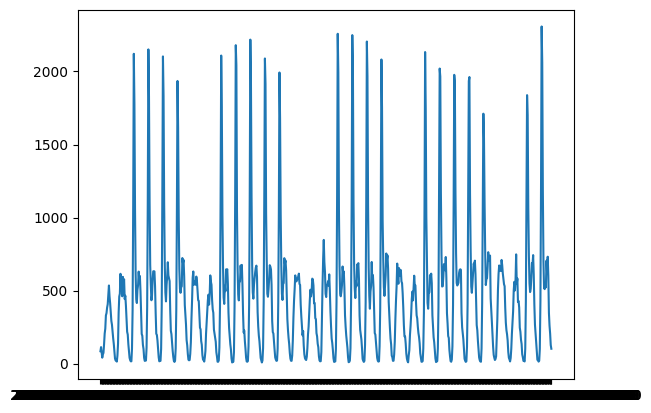

In [9]:
# plot the line for our graph

x_values = results_grouped["transit_timestamp"]
y_values = results_grouped["ridership"]

plt.plot(x_values, y_values)

